## Профилирование пользователей. Использование LDA (выделение тематики статей, прочитанных пользователями) для  для решения задач бинарной классификации оттока

In [58]:
# !pip install gensim
# !pip install razdel
# !pip install pymorphy2
# !pip install nltk

In [2]:
import pandas as pd

In [7]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [8]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [9]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [16]:
#предобработка текстов
import re
import numpy as np
import nltk
nltk.download()
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [17]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [18]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [19]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [20]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/tmp/ipykernel_29949/2296537027.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 14 s, sys: 179 ms, total: 14.2 s
Wall time: 14.2 s


In [21]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 1min 57s, sys: 0 ns, total: 1min 57s
Wall time: 1min 57s


А теперь в 3 строчки обучим нашу модель

In [22]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение

In [25]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 45.4 s, sys: 44.8 ms, total: 45.4 s
Wall time: 16.8 s


In [26]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [27]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(6, 0.2491908),
 (12, 0.1337363),
 (17, 0.15401039),
 (18, 0.06787944),
 (20, 0.08162036),
 (22, 0.2934624)]

In [28]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: исследование обнаружить станция житель центр препарат объект
topic_1: газ день погода дождь оборот озеро опасаться
topic_2: земля технология риск планета век операция система
topic_3: земля участок строительство проект характерный площадь планироваться
topic_4: банк млн цена рост составить рынок вырасти
topic_5: поверхность температура градус лауреат саммит звание сближение
topic_6: исследование возраст спрос страдать конкурс энергия nn
topic_7: американский сша российский новый россия санкция nn
topic_8: правительство закон глава бюджет nn россия тыс
topic_9: северный китай германия остров японский рейтинг япония
topic_10: исследование статья пациент женщина nn автор экипаж
topic_11: погибнуть террорист предмет боевик уничтожить провинция восточный
topic_12: фонд депутат run статья собственность федеральный собрание
topic_13: nn первый метод долг тема журнал публикация
topic_14: млрд россия путин владимир nn российский глава
topic_15: тело район мужчина взрыв произойти помощь

In [29]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [30]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.211012,0.0,0.000000,0.740012,0.000000
1,4896,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.136761
2,4897,0.0,0.0,0.000000,0.0,0.0,0.0,0.249098,0.000000,0.0,...,0.000000,0.0,0.153938,0.067977,0.0,0.081633,0.0,0.293493,0.000000,0.000000
3,4898,0.0,0.0,0.014319,0.0,0.0,0.0,0.190151,0.345133,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.439828,0.000000,0.000000
4,4899,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.296801,0.0,0.000000,0.000000,0.0,0.426506,0.0,0.000000,0.000000,0.000000


### Векторные представления пользователей

In [31]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [32]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [33]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.12016683, 0.30227473, 0.        , 0.        ,
       0.07609339, 0.        , 0.        , 0.04067375, 0.15119092,
       0.05831329, 0.        , 0.        , 0.07620773, 0.        ,
       0.        , 0.        , 0.07185816, 0.09234302, 0.        ])

# Заменим mean на median в функции расчета эмбеддингов пользователей get_user_embedding()

In [54]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [55]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0809233 , 0.        , 0.        ,
       0.        , 0.        , 0.00740531, 0.        , 0.10032402,
       0.        , 0.        , 0.        , 0.0099396 , 0.        ,
       0.        , 0.05790769, 0.1222563 , 0.11006598, 0.        ])

In [56]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера риа новость nn читать сообщение разговаривать автор сообщение откуда автор источник какихлибо основание подобный род репортаж откуда информация появиться журналист итог встреча госсекретарь сша джон керри nn позиция изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать безопасность счёт безопасность продолжить министр лавров москва система нато создавать проблема безопасность поэтому декларация недостаточно договариваться совместный система россия предлагать начинать путин посещать сша нужно вести речь очередной декларация гарантия проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал подчеркнуть глава мид газета коммерсантъ ссылаться дипломатический источник написать 

Теперь получим эмбединги для всех пользователей

In [57]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.006367,0.213258,0.000000,...,0.029157,0.0,0.038306,0.01988,0.000000,0.000000,0.078526,0.035929,0.000000,0.0
1,u108690,0.006696,0.000000,0.036024,0.0,0.0,0.007152,0.024511,0.102218,0.030221,...,0.021875,0.0,0.112250,0.00000,0.000000,0.000000,0.000000,0.144559,0.173057,0.0
2,u108339,0.020741,0.005005,0.038448,0.0,0.0,0.000000,0.000000,0.105755,0.047745,...,0.071551,0.0,0.016132,0.00000,0.007531,0.045459,0.158480,0.081897,0.128347,0.0


In [39]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [40]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.006367,0.213258,0.000000,...,0.0,0.038306,0.01988,0.000000,0.000000,0.078526,0.035929,0.000000,0.0,0
1,u108690,0.006696,0.000000,0.036024,0.0,0.0,0.007152,0.024511,0.102218,0.030221,...,0.0,0.112250,0.00000,0.000000,0.000000,0.000000,0.144559,0.173057,0.0,1
2,u108339,0.020741,0.005005,0.038448,0.0,0.0,0.000000,0.000000,0.105755,0.047745,...,0.0,0.016132,0.00000,0.007531,0.045459,0.158480,0.081897,0.128347,0.0,1


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [42]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [43]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [44]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.2015873 , 0.05607481, 0.51076794, 0.2074209 , 0.05134976,
       0.03042757, 0.31936272, 0.13432112, 0.24157381, 0.06573435])

In [45]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [46]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.298477, F-Score=0.813, Precision=0.818, Recall=0.808


In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [49]:
import itertools

Confusion matrix, without normalization
[[1711   44]
 [  48  197]]


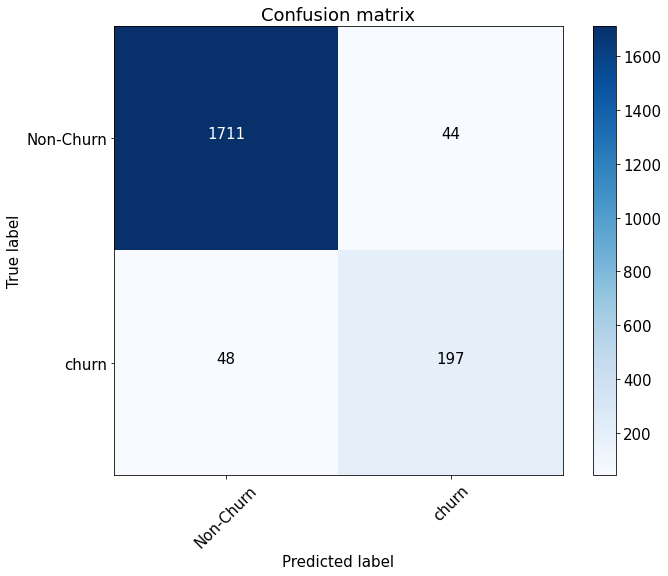

In [50]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [51]:
roc_auc_score(y_test, preds)

0.9815431129716844

### Итоги сравнения модели с mean vs median:

mean: Best Threshold=0.253757, F-Score=0.696, Precision=0.651, Recall=0.747, roc_auc 0.9507924879353452

median: Best Threshold=0.298477, F-Score=0.813, Precision=0.818, Recall=0.808, roc_auc 0.9815431129716844

Вывод: модель с расчетом медианы по каждой теме по последним просмотренным пользователем статьям работает намногот лучше, чем расчет среднего  по каждой теме по последним статьям.

### Проверим метрики работы модели, заменив медиану на максимальное значение

In [60]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [61]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [62]:
target = pd.read_csv("users_churn.csv")

In [63]:
X = pd.merge(user_embeddings, target, 'left')

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [66]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [67]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.0779361 , 0.00446488, 0.96308055, 0.00957916, 0.0018186 ,
       0.00365682, 0.05132875, 0.23766505, 0.0133226 , 0.20629604])

In [68]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.387018, F-Score=0.804, Precision=0.830, Recall=0.780


In [69]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1716   39]
 [  55  190]]


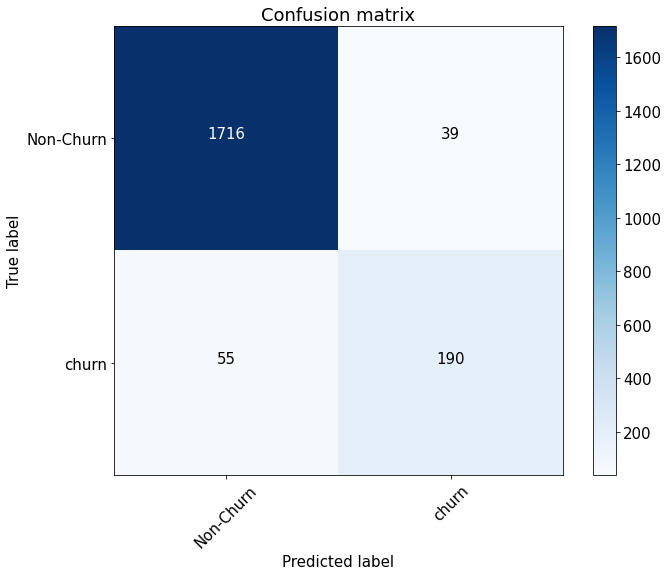

In [70]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [71]:
roc_auc_score(y_test, preds)

0.9764381650095936

Итоги сравнения модели с mean vs median vs max:

mean: Best Threshold=0.253757, F-Score=0.696, Precision=0.651, Recall=0.747, roc_auc 0.9507924879353452

median: Best Threshold=0.298477, F-Score=0.813, Precision=0.818, Recall=0.808, roc_auc 0.9815431129716844

max: Best Threshold=0.387018, F-Score=0.804, Precision=0.830, Recall=0.780, roc_auc 0.9764381650095936

Вывод: модель с расчетом медианы по каждой теме по последним просмотренным пользователем статьям работает намного лучше, чем расчет среднего по каждой теме по последним статьям. При этом модель с применением максимального значения вместо среднего и медианы работает лучше, чем со средним, но хуже, чем с медианой.
Для целей нашей задачи предпочтительно использовать медиану. Кроме того, с учетом специфики задачи (потенциальный отток пользователей), для нас предпочтительнее лучшие показатели recall, эти показатели лучше также при использовании медианы.

In [88]:
#Создадим таблицу сравнения показателей
table = pd.DataFrame([['mean', 0.253757,0.696,0.651,0.747,0.9507924879353452], ['median', 0.298477, 0.813, 0.818, 0.808, 0.9815431129716844], ['max', 0.387018, 0.804, 0.830, 0.780, 0.9764381650095936]], columns = ['mean/median/max', 'Best Threshold', 'F-Score', 'Precision', 'Recall', 'roc_auc'])

In [89]:
table.head()

,mean/median/max,Best Threshold,F-Score,Precision,Recall,roc_auc
0,mean,0.253757,0.696,0.651,0.747,0.950792
1,median,0.298477,0.813,0.818,0.808,0.981543
2,max,0.387018,0.804,0.830,0.780,0.976438


### Применение весов tfidf

In [243]:
users

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"
...,...,...
7995,u107463,"[323918, 323362, 323704, 323452, 324291, 251]"
7996,u101241,"[5532, 5860, 7755, 7140, 5182, 488337]"
7997,u106486,"[322811, 323898, 321858, 323345, 323491, 2193]"
7998,u102220,"[5436, 6092, 6891, 7045, 5320, 487379]"


In [244]:
users.shape

(8000, 2)

In [245]:
list_doc_names_all = []

In [246]:
for i in range(users.shape[0]):
    for j in eval(users['articles'].iloc[i]):
        list_doc_names_all.append(j)

In [247]:
len(list_doc_names_all)

48000

In [248]:
from collections import Counter
import math
count = Counter(list_doc_names_all)
count

Counter({293672: 3,
         293328: 4,
         293001: 3,
         293622: 1,
         293126: 5,
         1852: 3,
         3405: 3,
         1739: 2,
         2972: 1,
         1158: 5,
         1599: 2,
         322665: 8,
         1845: 5,
         2009: 1,
         2356: 4,
         1424: 3,
         2939: 4,
         323389: 8,
         5933: 4,
         6186: 5,
         5055: 2,
         6977: 3,
         5206: 5,
         488389: 4,
         707: 4,
         1144: 6,
         2532: 3,
         2928: 5,
         3133: 4,
         324592: 6,
         323868: 12,
         323426: 8,
         324267: 6,
         322426: 7,
         324104: 7,
         1550: 5,
         293138: 1,
         294471: 4,
         295012: 2,
         294736: 2,
         293949: 4,
         3544: 4,
         6928: 5,
         5009: 6,
         6940: 1,
         7629: 4,
         7644: 5,
         512736: 1,
         322838: 14,
         324699: 6,
         322991: 6,
         322120: 10,
         32432

In [249]:
tf = 1/6
tfidf = {}
for key in count.keys():
    tfidf[key] = tf*math.log(users.shape[0]/count[key])  

In [250]:
tfidf

{293672: 1.3147640886656438,
 293328: 1.266817076590347,
 293001: 1.3147640886656438,
 293622: 1.4978661367769954,
 293126: 1.2296264847046454,
 1852: 1.3147640886656438,
 3405: 1.3147640886656438,
 1739: 1.3823416066836711,
 2972: 1.4978661367769954,
 1158: 1.2296264847046454,
 1599: 1.3823416066836711,
 322665: 1.1512925464970227,
 1845: 1.2296264847046454,
 2009: 1.4978661367769954,
 2356: 1.266817076590347,
 1424: 1.3147640886656438,
 2939: 1.266817076590347,
 323389: 1.1512925464970227,
 5933: 1.266817076590347,
 6186: 1.2296264847046454,
 5055: 1.3823416066836711,
 6977: 1.3147640886656438,
 5206: 1.2296264847046454,
 488389: 1.266817076590347,
 707: 1.266817076590347,
 1144: 1.1992395585723195,
 2532: 1.3147640886656438,
 2928: 1.2296264847046454,
 3133: 1.266817076590347,
 324592: 1.1992395585723195,
 323868: 1.0837150284789954,
 323426: 1.1512925464970227,
 324267: 1.1992395585723195,
 322426: 1.17354777860111,
 324104: 1.17354777860111,
 1550: 1.2296264847046454,
 293138: 1.4

In [251]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id]*tfidf[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [252]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [253]:
target = pd.read_csv("users_churn.csv")

In [254]:
X = pd.merge(user_embeddings, target, 'left')

In [255]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [256]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [257]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [258]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.1570918 , 0.03778974, 0.59473467, 0.19910186, 0.02907758,
       0.01730733, 0.37805013, 0.11455057, 0.25407205, 0.06653787])

In [259]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.345283, F-Score=0.861, Precision=0.874, Recall=0.849


Confusion matrix, without normalization
[[1725   30]
 [  38  207]]


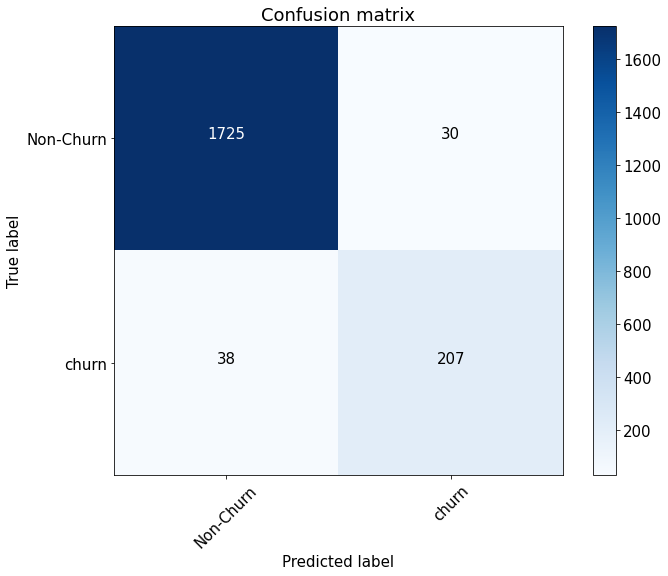

In [260]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [261]:
roc_auc_score(y_test, preds)

0.9886784115355545

In [262]:
#Создадим таблицу сравнения показателей
table = pd.DataFrame([['mean', 0.253757,0.696,0.651,0.747,0.9507924879353452], ['median', 0.298477, 0.813, 0.818, 0.808, 0.9815431129716844], ['max', 0.387018, 0.804, 0.830, 0.780, 0.9764381650095936], ['median_tfidf_users_docs', 0.345283,0.861, 0.874, 0.849, 0.9886784115355545]], columns = ['mean/median/max', 'Best Threshold', 'F-Score', 'Precision', 'Recall', 'roc_auc'])

In [263]:
table.head()

,mean/median/max,Best Threshold,F-Score,Precision,Recall,roc_auc
0,mean,0.253757,0.696,0.651,0.747,0.950792
1,median,0.298477,0.813,0.818,0.808,0.981543
2,max,0.387018,0.804,0.830,0.780,0.976438
3,median_tfidf_users_docs,0.345283,0.861,0.874,0.849,0.988678


Вывод: после применения весов tfidf, рассчитанных для статей в последних прочитанных пользователем шести статьях по всем пользователям метрики модели существенно улучшились. следует применить этот прием в данной задаче.